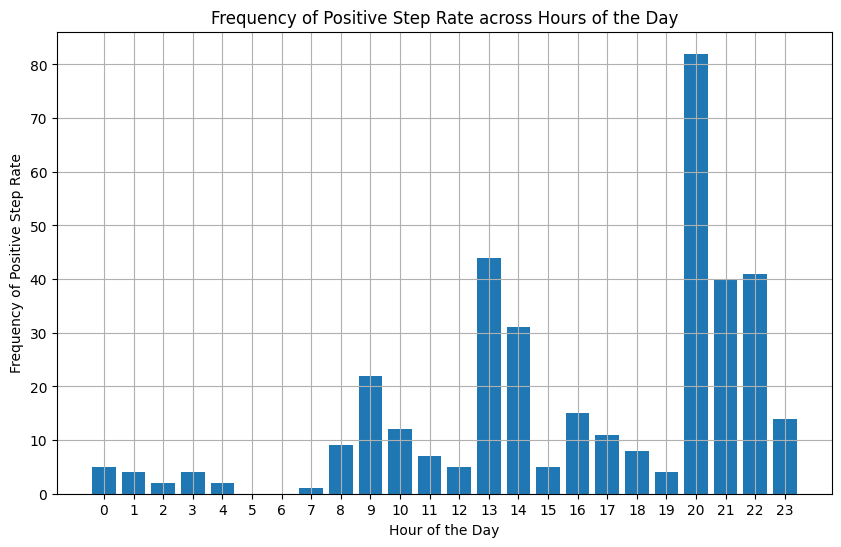

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def calculate_step_rate(input_directory, output_directory):
    for file_name in os.listdir(input_directory):
        # Check for Excel files
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            input_file = os.path.join(input_directory, file_name)
            output_file = os.path.join(output_directory, file_name)

            # Read the Excel file into a DataFrame
            df = pd.read_excel(input_file, parse_dates=['datetime'])

            # Calculate the step rate (steps/s)
            df['step_diff'] = df['RAW STEP COUNT'].diff()
            df['time_diff'] = df['datetime'].diff().dt.total_seconds()
            df['Step Rate (steps/s)'] = df['step_diff'] / df['time_diff']

            # Save the updated DataFrame to a new Excel file
            df.to_excel(output_file, index=False)
            

def apply_one_hot_encoding(input_directory, output_file):
    dfs = []

    for file_name in os.listdir(input_directory):
        # Check for Excel files
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            input_file = os.path.join(input_directory, file_name)

            # Read the Excel file into a DataFrame
            df = pd.read_excel(input_file, parse_dates=['datetime'])

            # Extract hour from datetime
            df['hour'] = df['datetime'].dt.hour

            # Round the 'RAW STEP COUNT' values to 2 decimal places
            df['RAW STEP COUNT'] = df['RAW STEP COUNT'].round(2)

            # Apply one-hot encoding
            condition = df['Step Rate (steps/s)'] > 0.1
            for hour in range(24):
                df[f'hour_{hour}'] = 0
                df.loc[condition & (df['hour'] == hour), f'hour_{hour}'] = 1

            # Keep only the one-hot encoded hour columns
            hour_columns = [f'hour_{i}' for i in range(24)]
            df = df[hour_columns]

            dfs.append(df)

    # Concatenate all DataFrames
    final_df = pd.concat(dfs)

    # Save the encoded DataFrame to a new Excel file
    final_df.to_excel(output_file, index=False)

def visualize_results(input_file):
    # Read the Excel file into a DataFrame
    df = pd.read_excel(input_file)

    # Plot the frequency of 1s in the one-hot encoded hour columns
    hour_columns = [col for col in df.columns if col.startswith('hour')]
    frequencies = df[hour_columns].sum()

    plt.figure(figsize=(10, 6))
    plt.bar(range(24), frequencies)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Frequency of Positive Step Rate')
    plt.title('Frequency of Positive Step Rate across Hours of the Day')
    plt.xticks(range(24))
    plt.grid(True)
    plt.show()

# Input and output directories
input_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\Dataset'
output_step_rate_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\StepRate'
output_encoded_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try'
output_encoded_file = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\output_encoded_result_step.xlsx'

# Ensure the output directories exist
os.makedirs(output_step_rate_directory, exist_ok=True)

# Step 1: Calculate step rate for each file and save them separately
calculate_step_rate(input_directory, output_step_rate_directory)

# Step 2: Apply one-hot encoding to the step rate files and save the result
apply_one_hot_encoding(output_step_rate_directory, os.path.join(output_encoded_directory, output_encoded_file))

# Step 3: Visualize the results
visualize_results(os.path.join(output_encoded_directory, output_encoded_file))


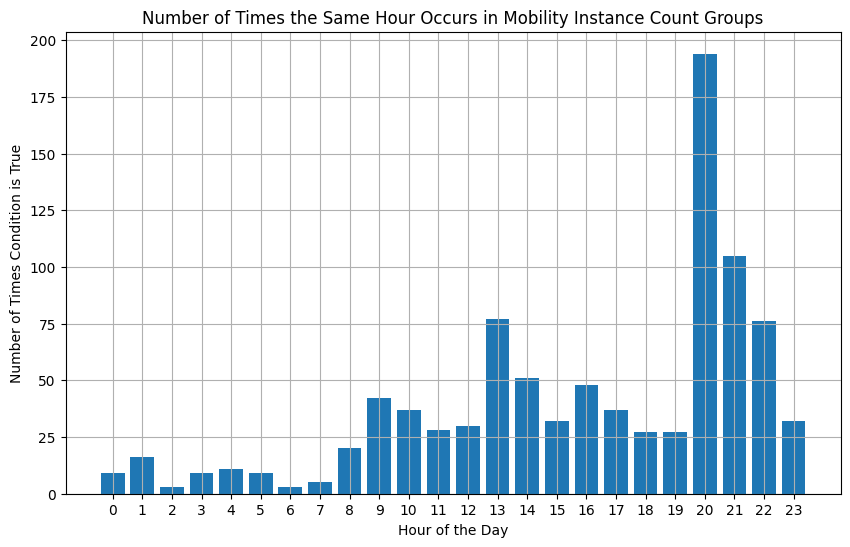

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def analyze_mobility_instance(input_directory, output_file):
    hour_count = {hour: 0 for hour in range(24)}

    for file_name in os.listdir(input_directory):
        # Check for Excel files
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            input_file = os.path.join(input_directory, file_name)

            # Read the Excel file into a DataFrame
            df = pd.read_excel(input_file, parse_dates=['datetime'])

            # Group by 'Mobility Instance Count' without sorting
            grouped = df.groupby('Mobility Instance Count')

            for name, group in grouped:
                # Check if the hour values within each group are the same
                if group['datetime'].dt.hour.nunique() == 1:
                    hour = group['datetime'].dt.hour.iloc[0]
                    hour_count[hour] += 1

    # Save the hour count data to a CSV file
    pd.DataFrame(list(hour_count.items()), columns=['Hour', 'Count']).to_csv(output_file, index=False)

    return hour_count

def plot_hour_count(hour_count):
    hours = list(hour_count.keys())
    counts = list(hour_count.values())

    plt.figure(figsize=(10, 6))
    plt.bar(hours, counts)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Times Condition is True')
    plt.title('Number of Times the Same Hour Occurs in Mobility Instance Count Groups')
    plt.xticks(range(24))
    plt.grid(True)
    plt.show()

# Input and output directories
input_directory = r'C:\Users\ahsani2\Documents\Week 15+16\ML Datasets (only days with full-day yield)\withMobilityInstance'
output_file = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\mobility_instance_hour_count.xlsx'

# Analyze the mobility instance data and get the hour count
hour_count = analyze_mobility_instance(input_directory, output_file)

# Plot the results
plot_hour_count(hour_count)


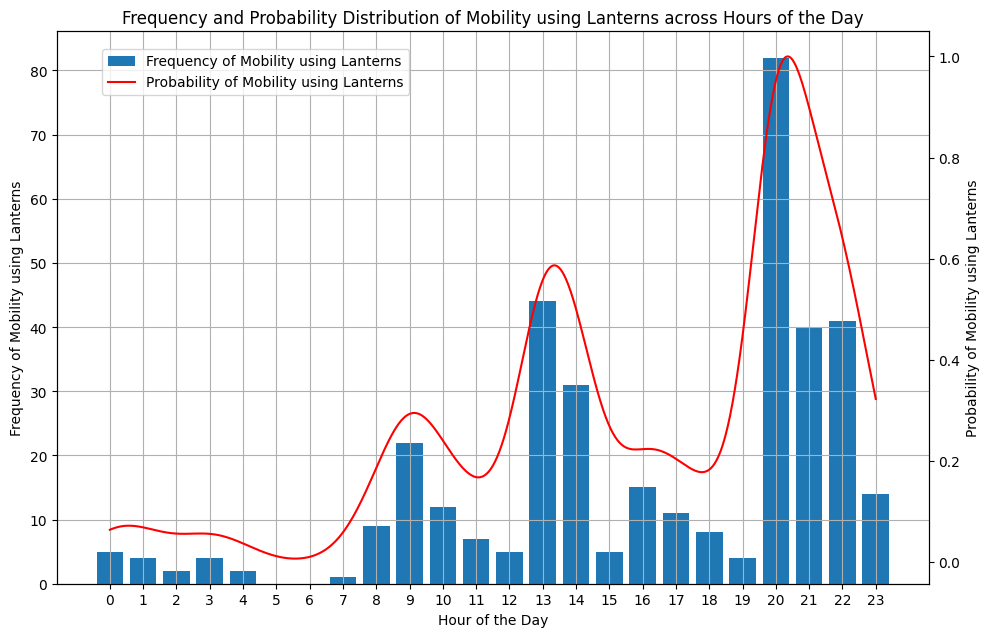

In [5]:
def visualize_results(input_file):
    # Read the Excel file into a DataFrame
    df = pd.read_excel(input_file)

    # Calculate the frequency of 1s in the one-hot encoded hour columns
    hour_columns = [col for col in df.columns if col.startswith('hour')]
    frequencies = df[hour_columns].sum()

    # Fit Kernel Density Estimation (KDE) on the hourly data points
    hourly_data = np.repeat(range(24), frequencies)
    bandwidth = 0.15  # Adjust this value for more or less smoothness
    kde_estimator = gaussian_kde(hourly_data, bw_method=bandwidth)
    x = np.linspace(0, 23, 1000)
    probability = kde_estimator(x) / kde_estimator(x).sum()  # Normalize to get probability
    probability /= probability.max()  # Normalize to 1

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar plot on the primary y-axis with actual values
    ax1.bar(range(24), frequencies, color='#1f77b4', label='Frequency of Mobility using Lanterns')
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Frequency of Mobility using Lanterns')
    ax1.set_title('Frequency and Probability Distribution of Mobility using Lanterns across Hours of the Day')
    ax1.set_xticks(range(24))
    ax1.grid(True)

    # KDE plot on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(x, probability, color='r', label='Probability of Mobility using Lanterns')
    ax2.set_ylabel('Probability of Mobility using Lanterns')

    # Add legends outside of the plot area
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.1, 1))

    # Adjust layout to make room for the legend
    fig.tight_layout(rect=[0, 0, 1, 1.08])  # Adjust rect to leave space on the top for the legend

    plt.show()

# Input and output directories
input_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\Dataset'
output_step_rate_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\StepRate'
output_encoded_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try'
output_encoded_file = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\output_encoded_result_step.xlsx'

# Ensure the output directories exist
os.makedirs(output_step_rate_directory, exist_ok=True)

# Step 1: Calculate step rate for each file and save them separately
calculate_step_rate(input_directory, output_step_rate_directory)

# Step 2: Apply one-hot encoding to the step rate files and save the result
apply_one_hot_encoding(output_step_rate_directory, os.path.join(output_encoded_directory, output_encoded_file))

# Step 3: Visualize the results with KDE
visualize_results(os.path.join(output_encoded_directory, output_encoded_file))


Step 1: Calculated frequencies for each hour for all lanterns:
Hour 0: 2
Hour 1: 2
Hour 2: 2
Hour 3: 1
Hour 4: 1
Hour 5: 0
Hour 6: 0
Hour 7: 1
Hour 8: 3
Hour 9: 5
Hour 10: 7
Hour 11: 3
Hour 12: 4
Hour 13: 9
Hour 14: 7
Hour 15: 3
Hour 16: 3
Hour 17: 5
Hour 18: 4
Hour 19: 2
Hour 20: 15
Hour 21: 10
Hour 22: 8
Hour 23: 4

Step 2: Calculated probabilities for each hour:
Hour 0: 0.06666666666666667
Hour 1: 0.06666666666666667
Hour 2: 0.06666666666666667
Hour 3: 0.03333333333333333
Hour 4: 0.03333333333333333
Hour 5: 0.0
Hour 6: 0.0
Hour 7: 0.03333333333333333
Hour 8: 0.1
Hour 9: 0.16666666666666666
Hour 10: 0.23333333333333334
Hour 11: 0.1
Hour 12: 0.13333333333333333
Hour 13: 0.3
Hour 14: 0.23333333333333334
Hour 15: 0.1
Hour 16: 0.1
Hour 17: 0.16666666666666666
Hour 18: 0.13333333333333333
Hour 19: 0.06666666666666667
Hour 20: 0.5
Hour 21: 0.3333333333333333
Hour 22: 0.26666666666666666
Hour 23: 0.13333333333333333


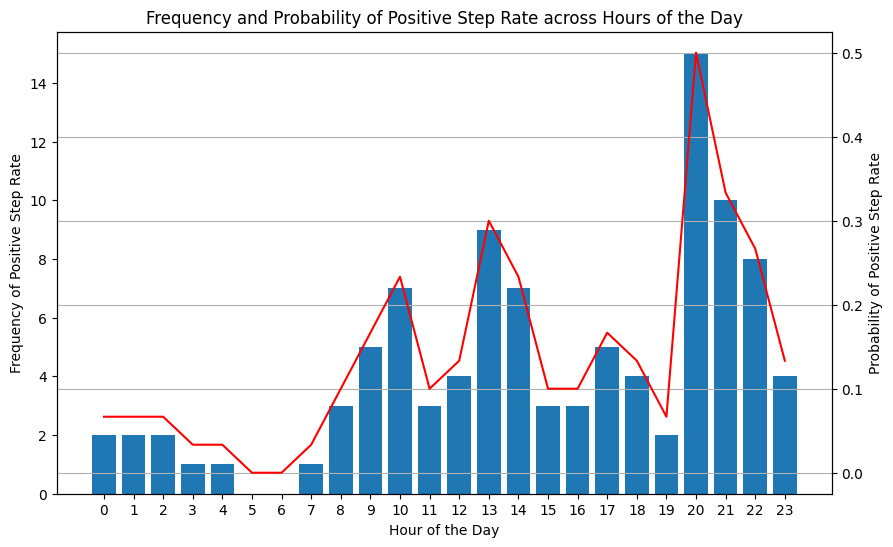

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def calculate_step_rate(input_directory, output_directory):
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            input_file = os.path.join(input_directory, file_name)
            output_file = os.path.join(output_directory, file_name)

            df = pd.read_excel(input_file, parse_dates=['datetime'])

            df['step_diff'] = df['RAW STEP COUNT'].diff()
            df['time_diff'] = df['datetime'].diff().dt.total_seconds()
            df['Step Rate (steps/s)'] = df['step_diff'] / df['time_diff']

            df.to_excel(output_file, index=False)

def apply_one_hot_encoding(input_directory, output_file):
    frequencies = {hour: [0] * 24 for hour in range(24)}
    total_lanterns = 0

    for file_name in os.listdir(input_directory):
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            input_file = os.path.join(input_directory, file_name)
            df = pd.read_excel(input_file, parse_dates=['datetime'])
            df['hour'] = df['datetime'].dt.hour

            condition = df['Step Rate (steps/s)'] > 0.1
            hours_checked = set()

            for index, row in df.iterrows():
                hour = row['hour']
                if hour not in hours_checked and condition[index]:
                    frequencies[hour][hour] += 1
                    hours_checked.add(hour)

            total_lanterns += 1

    print("Step 1: Calculated frequencies for each hour for all lanterns:")
    for hour, freq_list in frequencies.items():
        print(f"Hour {hour}: {sum(freq_list)}")

    probabilities = {hour: sum(frequencies[hour]) / total_lanterns for hour in range(24)}

    print("\nStep 2: Calculated probabilities for each hour:")
    for hour, prob in probabilities.items():
        print(f"Hour {hour}: {prob}")

    df_result = pd.DataFrame(frequencies)
    df_result.index.name = 'Lantern K'
    df_result.to_excel(output_file, index=False)

    return df_result, probabilities

def visualize_results(input_file, frequencies, probabilities):
    df = pd.read_excel(input_file)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    for hour in df.columns:
        ax1.bar(int(hour), df[hour].sum(), color='#1f77b4')

    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Frequency of Positive Step Rate')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.plot(range(24), list(probabilities.values()), color='red', linestyle='-')
    ax2.set_ylabel('Probability of Positive Step Rate')
    ax2.tick_params(axis='y')

    plt.title('Frequency and Probability of Positive Step Rate across Hours of the Day')
    plt.xticks(range(24))
    plt.grid(True)
    plt.show()

# Input and output directories
input_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\Dataset'
output_step_rate_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\StepRate'
output_encoded_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try'
output_encoded_file = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\output_encoded_result_step.xlsx'

# Ensure the output directories exist
os.makedirs(output_step_rate_directory, exist_ok=True)

# Step 1: Calculate step rate for each file and save them separately
calculate_step_rate(input_directory, output_step_rate_directory)

# Step 2: Apply one-hot encoding to the step rate files and save the result
result_df, probabilities = apply_one_hot_encoding(output_step_rate_directory, os.path.join(output_encoded_directory, output_encoded_file))

# Step 3: Visualize the results
visualize_results(os.path.join(output_encoded_directory, output_encoded_file), result_df, probabilities)


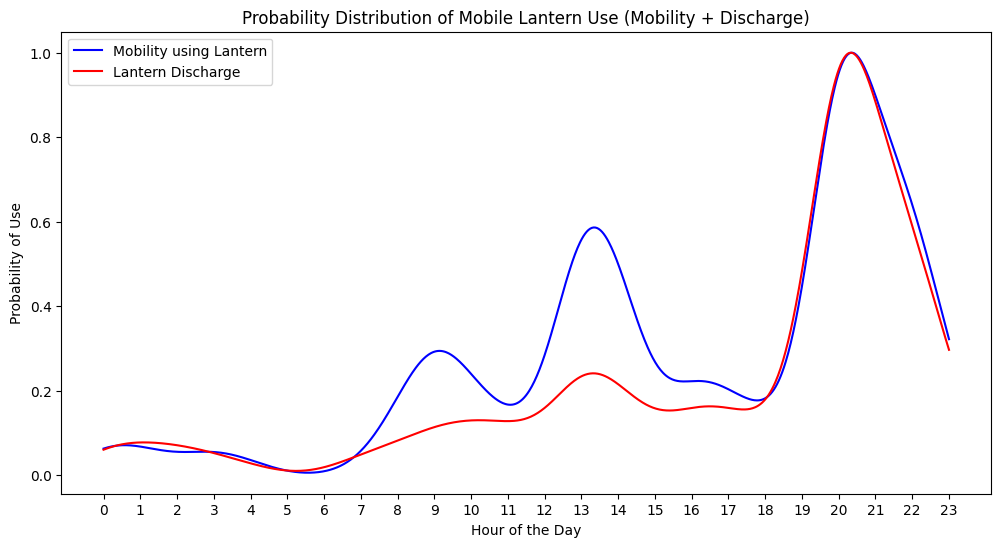

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Function from the first code to calculate step rate and generate hourly data
def calculate_step_rate_and_hourly_data(input_directory, output_directory):
    hourly_data_list = []
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            input_file = os.path.join(input_directory, file_name)
            output_file = os.path.join(output_directory, file_name)
            df = pd.read_excel(input_file, parse_dates=['datetime'])
            df['step_diff'] = df['RAW STEP COUNT'].diff()
            df['time_diff'] = df['datetime'].diff().dt.total_seconds()
            df['Step Rate (steps/s)'] = df['step_diff'] / df['time_diff']
            df.to_excel(output_file, index=False)
            df['hour'] = df['datetime'].dt.hour
            condition = df['Step Rate (steps/s)'] > 0.1
            hourly_data_list.append(df.loc[condition, 'hour'])
    return np.concatenate(hourly_data_list)

# Input and output directories for the first code
input_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\Dataset'
output_step_rate_directory = r'C:\Users\ahsani2\Documents\03- AI part\03 - Third Try\StepRate'
os.makedirs(output_step_rate_directory, exist_ok=True)
hourly_data_set1 = calculate_step_rate_and_hourly_data(input_directory, output_step_rate_directory)

# Provided data for the second code
hours = np.arange(24)
frequency_of_use = np.array([12, 12, 11, 8, 4, 0, 1, 8, 11, 18, 20, 19, 13, 47, 33, 15, 26, 25, 17, 21, 223, 110, 95, 37])
hourly_data_set2 = np.repeat(hours, frequency_of_use)

# Fit KDE for both sets
bandwidth = 0.15
kde_set1 = gaussian_kde(hourly_data_set1, bw_method=bandwidth)
kde_set2 = gaussian_kde(hourly_data_set2, bw_method=bandwidth)

# Create x values for plotting
x = np.linspace(0, 23, 1000)

# Calculate KDE values
probability_set1 = kde_set1(x) / kde_set1(x).sum()
probability_set2 = kde_set2(x) / kde_set2(x).sum()

# Normalize probabilities to 1
probability_set1 /= probability_set1.max()
probability_set2 /= probability_set2.max()

# Plotting the KDEs
plt.figure(figsize=(12, 6))

plt.plot(x, probability_set1, label='Mobility using Lantern', color='b')
plt.plot(x, probability_set2, label='Lantern Discharge', color='r')

plt.xlabel('Hour of the Day')
plt.ylabel('Probability of Use')
plt.title('Probability Distribution of Mobile Lantern Use (Mobility + Discharge)')
plt.legend()

# Set x-ticks to display all 24 values
plt.xticks(np.arange(24))

plt.show()
